In [13]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

import word2vec
from data_loader import load_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils import plot_confusion_matrix
from utils import timeSince

import time

In [14]:
dim_word2vec = 50

batch_size = 16
epochs = 5
learning_rate = 1e-4
model_fn = '../results/rnn_tc/rnn_tc_LSTM.11180355.pt'

In [15]:
# glov_wv = word2vec.load_wv('../data/word2vec/glove.twitter.27B/word2vec.%dd.txt' % dim_word2vec)
glov_wv = word2vec.load_wv_from_model('../data/word2vec/retrained_word2vec/reddit_word2vec')

loading word2vec...


In [16]:
data_train, label_train = load_data('../data/train.csv')
data_test, label_test = load_data('../data/test.csv')

#check number of labels in each class
tmp = label_test.tolist()
for label in np.unique(label_test):
    print('{}: {}'.format(label, tmp.count(label)))

tmp2 = label_train.tolist()
for label in np.unique(label_train):
    print('{}: {}'.format(label, tmp2.count(label)))

def avg_length(sentences):
    N = len(sentences)
    all_length = 0
    for sentence in sentences:
        all_length += len(sentence)

    return all_length / N    

def txt2vector(sentences, dic, dim, pad_length=14):
    vectors = []
    count = 0
    
    for sentence in sentences:
        vector = []
        for word in word2vec.preprocess(sentence[0]):
            if len(vector) <= pad_length and word in dic:
                vector.append(dic[word])
            
            if word not in dic:
                count += 1
        
        while len(vector) <= pad_length:
            vector.append(np.ones(dim))
            
        vectors.append(vector)
        
    print('missing words: %d, avg missing words: %f' % (count, count / sentences.shape[0]))
    return np.array(vectors)

data_train_vec = txt2vector(data_train, glov_wv, dim_word2vec, 15)
data_test_vec = txt2vector(data_test, glov_wv, dim_word2vec, 15)

all_categories = np.unique(label_train).tolist()
print('categories:', all_categories)

def label2vector(labels, all_categories):
    return np.array([all_categories.index(label) for label in labels])

label_train_vec = label2vector(label_train, all_categories)
label_test_vec = label2vector(label_test, all_categories)

education: 1020
politics: 1084
science: 1036
sports: 1000
education: 4065
politics: 4356
science: 4147
sports: 4000
missing words: 22601, avg missing words: 1.364136
missing words: 5691, avg missing words: 1.374638
categories: ['education', 'politics', 'science', 'sports']


In [17]:
class RNN_tc(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_tc, self).__init__()
        self.num_layer = 1
        self.num_directions = 1
        
        self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)        
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.i2o = nn.Linear(hidden_size, output_size)        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, cn):
        output, (hidden, cn) = self.rnn(input, (hidden, cn))     
        output = self.i2o(output[:, -1, :])     
        output = self.softmax(output)   
        return output, (hidden, cn)
    
    def initHidden(self, batch_size):
        return torch.zeros(self.num_layer*self.num_directions, batch_size, self.hidden_size)
    
    def initState(self, batch_size):
        return torch.zeros(self.num_layer*self.num_directions, batch_size, self.hidden_size)

In [18]:
def batch_iter(X, y, batch_size=64, shuffle=True):
    N = len(X)
    num_batch = int((N - 1) / batch_size) + 1
    
    if shuffle:
        indices = np.random.permutation(np.arange(N))
        X_shuffle = X[indices]
        y_shuffle = y[indices]
    else:
        X_shuffle = X
        y_shuffle = y
    
    for i in range(num_batch):
        start_idx = i * batch_size
        end_idx = min((i+1) * batch_size, N)
        yield torch.tensor(X_shuffle[start_idx: end_idx], dtype=torch.float), torch.tensor(y_shuffle[start_idx: end_idx])

In [19]:
n_class = len(all_categories)
n_training = len(data_train)

model = RNN_tc(dim_word2vec, 200, n_class)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.NLLLoss()

losses = []

start = time.time()
min_loss = 1e+5

# test = 0

for epoch in range(epochs):
#     scheduler.step()
    idx = 0
    for X_batch, y_batch in batch_iter(data_train_vec, label_train_vec, batch_size):
        
        cur_batch_size = y_batch.size()[0]
        
        hidden = model.initHidden(cur_batch_size)
        cn = model.initState(cur_batch_size)
        
        output, hidden = model(X_batch, hidden, cn)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)        
        optimizer.step()        
        
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model, model_fn)
        
        idx += 1
        
        if idx % 100 == 0:
            losses.append(loss.item())
            print('%s, %d epoch, %d index, %f loss' % (timeSince(start),epoch, idx, loss.item()))            
        

/Users/zhengcao/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_tc. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0m 2s, 0 epoch, 100 index, 1.238313 loss
0m 4s, 0 epoch, 200 index, 1.124761 loss
0m 6s, 0 epoch, 300 index, 0.869920 loss
0m 8s, 0 epoch, 400 index, 0.442529 loss
0m 10s, 0 epoch, 500 index, 0.341786 loss
0m 11s, 0 epoch, 600 index, 0.234509 loss
0m 13s, 0 epoch, 700 index, 0.074497 loss
0m 15s, 0 epoch, 800 index, 0.291286 loss
0m 18s, 0 epoch, 900 index, 0.318942 loss
0m 20s, 0 epoch, 1000 index, 0.112149 loss
0m 23s, 1 epoch, 100 index, 0.495199 loss
0m 25s, 1 epoch, 200 index, 0.213978 loss
0m 27s, 1 epoch, 300 index, 0.217861 loss
0m 29s, 1 epoch, 400 index, 0.454293 loss
0m 31s, 1 epoch, 500 index, 0.291977 loss
0m 34s, 1 epoch, 600 index, 0.322284 loss
0m 36s, 1 epoch, 700 index, 0.126333 loss
0m 38s, 1 epoch, 800 index, 0.170502 loss
0m 40s, 1 epoch, 900 index, 0.179800 loss
0m 43s, 1 epoch, 1000 index, 0.075389 loss
0m 46s, 2 epoch, 100 index, 0.208278 loss
0m 49s, 2 epoch, 200 index, 0.201986 loss
0m 52s, 2 epoch, 300 index, 0.060649 loss
0m 54s, 2 epoch, 400 index, 0.339812

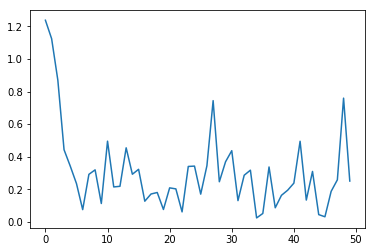

In [20]:
plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.show()

Confusion matrix, without normalization
[[ 896   40   46   38]
 [  13 1024    9   38]
 [  20   20  976   20]
 [  10   23   16  951]]


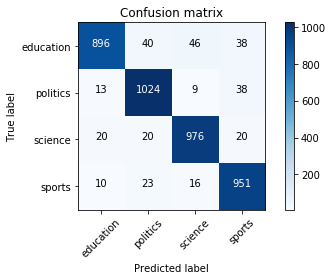

              precision    recall  f1-score   support

   education       0.95      0.88      0.91      1020
    politics       0.93      0.94      0.93      1084
     science       0.93      0.94      0.94      1036
      sports       0.91      0.95      0.93      1000

   micro avg       0.93      0.93      0.93      4140
   macro avg       0.93      0.93      0.93      4140
weighted avg       0.93      0.93      0.93      4140



In [22]:
def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

y_preds = []
for X_batch, y_batch in batch_iter(data_test_vec, label_test_vec, 1, False):
    
    cur_batch_size = y_batch.size()[0]    
    
    hidden = model.initHidden(cur_batch_size)
    cn = model.initHidden(cur_batch_size)    
    
    output, hidden = model(X_batch, hidden, cn)    

    for r in output:
        y_preds.append(category_from_output(r, all_categories))

cnf_matrix = confusion_matrix(label_test, y_preds)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=all_categories, title='Confusion matrix')
plt.show()

print(classification_report(label_test, y_preds))